# 신용카드 고객 세그먼트 분류 및 데이터 분석 (Credit Card Customer Segmentation)

## 1. 데이터셋 개요
본 노트는 2018년 7월부터 12월까지의 신용카드 고객 데이터를 활용하여 고객의 특성을 분석하고, 신용 등급(또는 세그먼트)을 예측하는 모델을 개발하는 과정을 다룹니다.

### 데이터 구성
- **기간**: 2018.07 ~ 2018.12 (6개월)
- **데이터 종류**:
  1. **회원정보**: 고객의 인구통계학적 특성 (나이, 성별, 소득 등)
  2. **신용정보**: 신용도 관련 정보
  3. **승인매출정보**: 카드 사용 내역
  4. **청구정보**: 대금 청구 내역
  5. **잔액정보**: 결제 후 잔액 정보
  6. **채널정보**: 카드 발급 채널 등
  7. **마케팅정보**: 마케팅 수신 동의 여부 등
  8. **성과정보**: 타겟 변수 관련 정보 (Train Set에만 존재하거나 Target 유추 가능)

### 목표
- 데이터 탐색적 분석(EDA)을 통해 인사이트 도출
- 다양한 정보를 결합하여 유의미한 파생 변수 생성 (Feature Engineering)
- 머신러닝 모델링 및 앙상블을 통한 예측 성능 극대화
- 상위 4개 모델을 선별하여 앙상블 모델 구축 및 평가

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import warnings

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 설정
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.rc('font', family='Malgun Gothic') # Windows 한글 폰트
plt.rcParams['axes.unicode_minus'] = False

## 2. 데이터 로드 및 통합
월별, 정보별로 분산된 파케이(Parquet) 파일들을 로드하고 하나의 데이터프레임으로 통합합니다.

In [7]:
def load_and_merge_data(base_path, split='train'):
    """
    지정된 경로에서 데이터를 로드하고 병합하는 함수
    base_path: 데이터가 위치한 기본 경로 (예: './data')
    split: 'train' 또는 'test'
    """
    # 서브폴더 목록 (순서 중요: 1.회원정보가 기준이 될 가능성 높음)
    # 폴더 구조: ./data/train/1.회원정보/201807_train_회원정보.parquet
    
    # 정보 유형 정의
    info_types = {
        'member': '1.회원정보',
        'credit': '2.신용정보',
        'sales': '3.승인매출정보',
        'billing': '4.청구입금정보',
        'balance': '5.잔액정보',
        'channel': '6.채널정보',
        'marketing': '7.마케팅정보',
        'performance': '8.성과정보'
    }
    
    merged_df = None
    
    # 기준이 되는 회원정보 로드 및 병합 (월별 데이터 통합)
    member_path = os.path.join(base_path, split, info_types['member'])
    member_files = sorted(glob.glob(os.path.join(member_path, '*.parquet')))
    
    if not member_files:
        print(f"No files found in {member_path}")
        return None

    print(f"Loading {split} member data...")
    dfs = []
    for f in member_files:
        df = pd.read_parquet(f)
        dfs.append(df)
    merged_df = pd.concat(dfs, ignore_index=True)
    
    # 나머지 정보들도 로드하여 병합 (필요 시)
    # 주의: 데이터 양이 많을 경우 메모리 문제 발생 가능. 여기서는 주요 정보 위주로 병합하거나
    # 집계(Aggregation) 후 병합하는 방식을 고려해야 합니다.
    # 예시로 여기서는 회원정보를 메인으로 하고, 다른 정보는 로직에 따라 추가할 수 있습니다.
    # 실제로는 모든 파일을 다 로드하면 메모리가 부족할 수 있습니다.
    
    # 간단한 EDA 및 모델링을 위해 '회원정보'와 Target이 있는 '성과정보'(Train만)를 병합해 봅니다.
    
    if split == 'train':
        perf_path = os.path.join(base_path, split, info_types['performance'])
        perf_files = sorted(glob.glob(os.path.join(perf_path, '*.parquet')))
        if perf_files:
            print(f"Loading {split} performance data...")
            perf_dfs = []
            for f in perf_files:
                perf_dfs.append(pd.read_parquet(f))
            perf_df = pd.concat(perf_dfs, ignore_index=True)
            
            # 병합 키 확인 (보통 masking_no 등)
            # 여기서는 'masking_no'라고 가정하고 병합
            # 중복 컬럼 제거
            cols_to_use = perf_df.columns.difference(merged_df.columns).tolist()
            cols_to_use.append('masking_no') # key column
            
            try:
                if 'masking_no' in merged_df.columns and 'masking_no' in perf_df.columns:
                    merged_df = pd.merge(merged_df, perf_df[cols_to_use], on='masking_no', how='left')
                    print("Merged performance data.")
            except Exception as e:
                print(f"Merge failed: {e}")
    
    return merged_df

try:
    # 경로 설정 (실제 환경에 맞게 수정 필요)
    data_path = './data'
    train = load_and_merge_data(data_path, 'train')
    test = load_and_merge_data(data_path, 'test')
    
    print(f"Train shape: {train.shape}")
    print(f"Test shape: {test.shape}")
    display(train.head())
except Exception as e:
    print(f"Error loading data: {e}")
    # Fallback to creating dummy data if files are missing for demonstration
    print("Creating dummy data for demonstration...")
    train = pd.DataFrame({
        'masking_no': range(100),
        'age': np.random.randint(20, 70, 100),
        'income': np.random.randint(3000, 10000, 100),
        'gender': np.random.choice(['M', 'F'], 100),
        'Segment': np.random.randint(0, 3, 100)
    })
    test = pd.DataFrame({
        'masking_no': range(100, 150),
        'age': np.random.randint(20, 70, 50),
        'income': np.random.randint(3000, 10000, 50),
        'gender': np.random.choice(['M', 'F'], 50)
    })

Loading train member data...
Loading train performance data...
Loading test member data...
Train shape: (2400000, 78)
Test shape: (600000, 77)


,기준년월,ID,남녀구분코드,연령,Segment,회원여부_이용가능,회원여부_이용가능_CA,회원여부_이용가능_카드론,소지여부_신용,소지카드수_유효_신용,소지카드수_이용가능_신용,입회일자_신용,입회경과개월수_신용,회원여부_연체,이용거절여부_카드론,동의여부_한도증액안내,수신거부여부_TM,수신거부여부_DM,수신거부여부_메일,수신거부여부_SMS,가입통신회사코드,탈회횟수_누적,최종탈회후경과월,탈회횟수_발급6개월이내,탈회횟수_발급1년이내,거주시도명,직장시도명,마케팅동의여부,유효카드수_신용체크,유효카드수_신용,유효카드수_신용_가족,유효카드수_체크,유효카드수_체크_가족,이용가능카드수_신용체크,이용가능카드수_신용,이용가능카드수_신용_가족,이용가능카드수_체크,이용가능카드수_체크_가족,이용카드수_신용체크,이용카드수_신용,이용카드수_신용_가족,이용카드수_체크,이용카드수_체크_가족,이용금액_R3M_신용체크,이용금액_R3M_신용,이용금액_R3M_신용_가족,이용금액_R3M_체크,이용금액_R3M_체크_가족,_1순위카드이용금액,_1순위카드이용건수,_1순위신용체크구분,_2순위카드이용금액,_2순위카드이용건수,_2순위신용체크구분,최종유효년월_신용_이용가능,최종유효년월_신용_이용,최종카드발급일자,보유여부_해외겸용_본인,이용가능여부_해외겸용_본인,이용여부_3M_해외겸용_본인,보유여부_해외겸용_신용_본인,이용가능여부_해외겸용_신용_본인,이용여부_3M_해외겸용_신용_본인,연회비발생카드수_B0M,연회비할인카드수_B0M,기본연회비_B0M,제휴연회비_B0M,할인금액_기본연회비_B0M,할인금액_제휴연회비_B0M,청구금액_기본연회비_B0M,청구금액_제휴연회비_B0M,상품관련면제카드수_B0M,임직원면제카드수_B0M,우수회원면제카드수_B0M,기타면제카드수_B0M,카드신청건수,Life_Stage,최종카드발급경과월
0,201807,TRAIN_000000,2,40대,D,1,1,0,1,1,1,20130101,67,0,0,1,0,0,0,0,L사,1,61,0,0,서울,서울,1,2,1,0,1,0,2,1,0,1,0,1,1,0,0,0,196,196,0,0,0,3681,26,신용,0,0,체크,202110.0,202112.0,20160912.0,0,0,0,0,0,0,0개,0,0,0,0,0,0,0,0개,0개,0개,0개,0,자녀성장(2),22
1,201807,TRAIN_000001,1,30대,E,1,1,1,1,1,1,20170801,12,0,0,0,0,0,0,0,K사,1,98,0,0,경기,경기,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,13475,13475,0,0,0,13323,46,신용,0,0,None,202112.0,202204.0,20170122.0,0,0,0,0,0,0,0개,0,0,0,0,0,0,0,0개,0개,0개,0개,0,자녀성장(1),18
2,201807,TRAIN_000002,1,30대,C,1,1,0,1,1,1,20080401,124,0,0,1,0,0,0,0,S사,1,60,0,0,서울,서울,1,2,1,0,1,0,2,1,0,1,0,1,1,0,0,0,23988,23988,0,0,0,24493,28,신용,0,0,체크,202111.0,202201.0,20161113.0,1,1,0,0,0,0,0개,0,0,0,0,0,0,0,0개,0개,0개,0개,0,자녀출산기,20
3,201807,TRAIN_000003,2,40대,D,1,1,0,1,2,2,20160501,27,0,0,1,0,0,0,0,L사,1,100,0,0,부산,부산,1,3,2,0,1,0,3,2,0,1,0,1,1,0,0,0,3904,3904,0,0,0,5933,1,신용,0,0,체크,202201.0,202111.0,20170205.0,1,1,1,1,1,1,0개,0,0,0,0,0,0,0,0개,0개,0개,0개,1,자녀성장(2),17
4,201807,TRAIN_000004,2,40대,E,1,1,1,1,1,1,20180601,2,0,0,0,0,0,0,0,K사,1,101,0,0,광주,광주,1,2,1,0,1,0,2,1,0,1,0,1,0,0,1,0,1190,0,0,1190,0,0,-2,신용,0,0,체크,202201.0,NaN,20170409.0,1,1,1,0,0,0,0개,0,0,0,0,0,0,0,0개,0개,0개,0개,1,자녀성장(1),15


## 3. 데이터 탐색적 분석 (EDA)
데이터의 분포, 이상치, 변수 간 상관관계를 시각화하여 파악합니다.

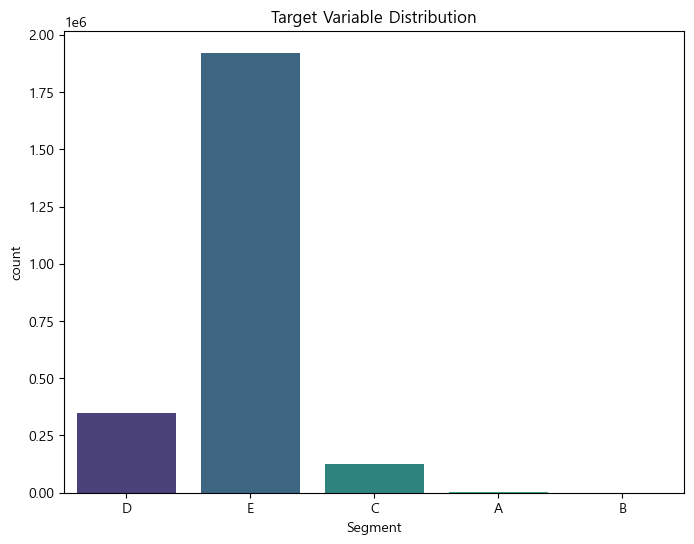

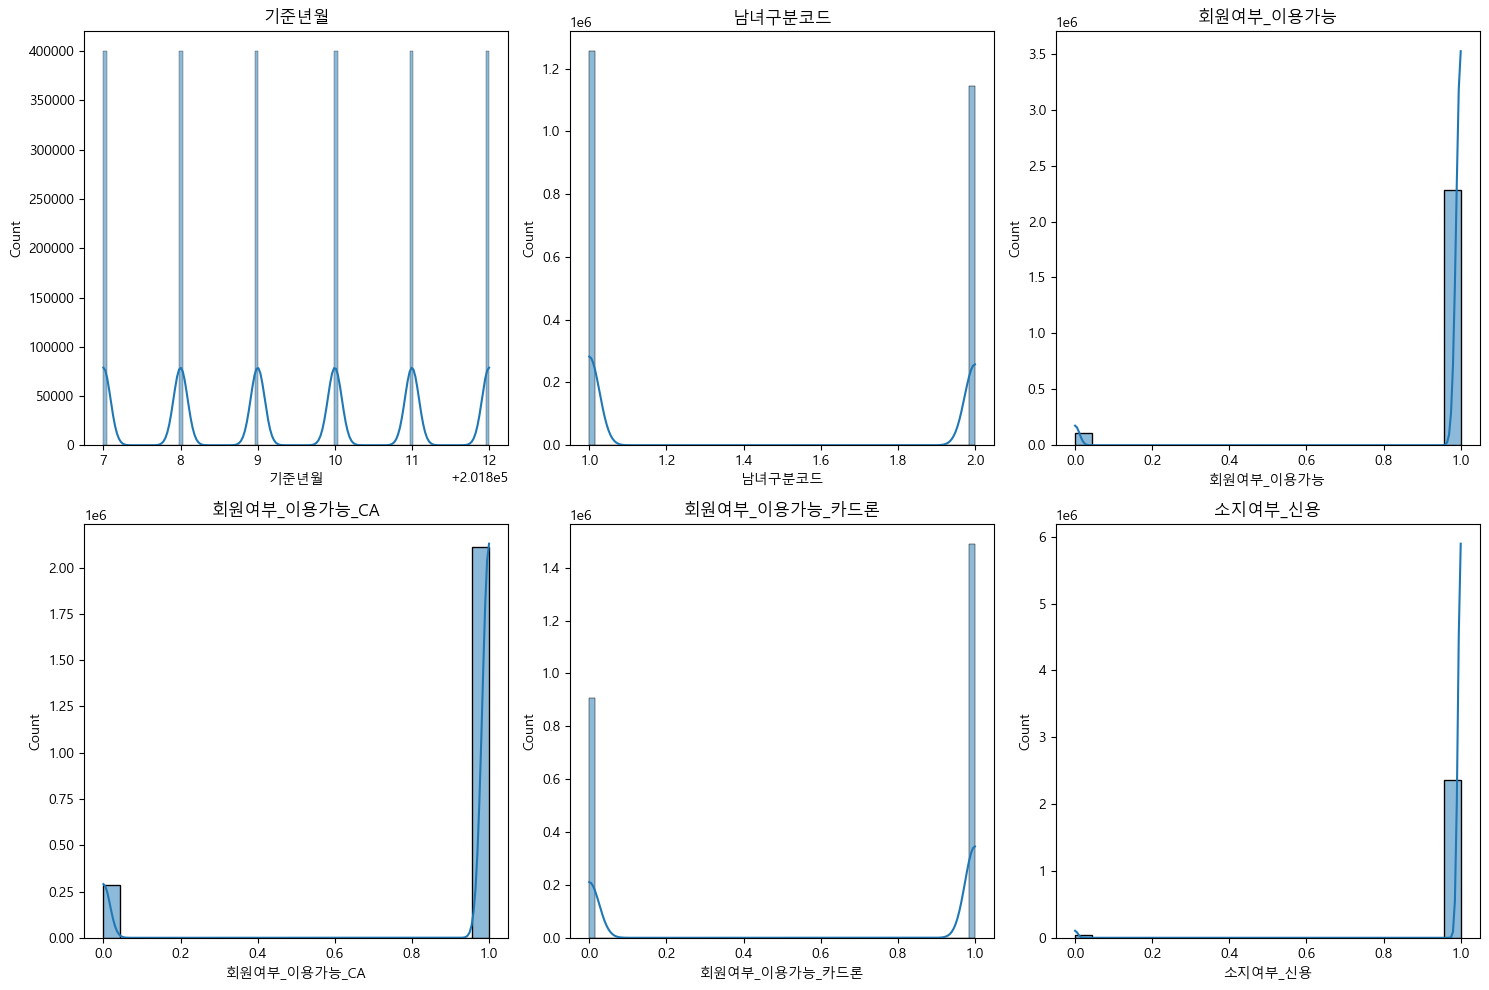

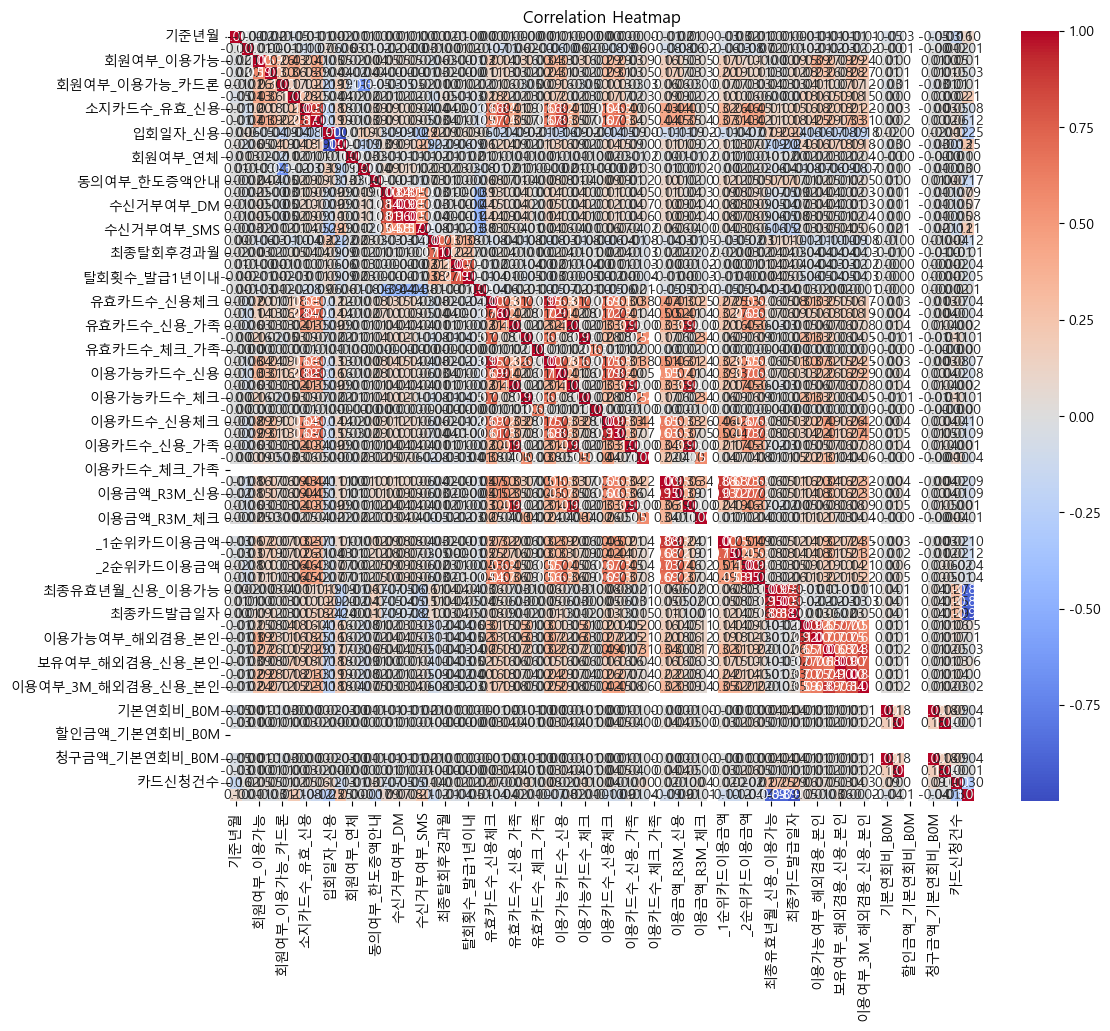

In [8]:
# Target 변수 분포 확인
target_col = 'Segment' # Target 컬럼명 수정 (credit -> Segment)
if target_col in train.columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=target_col, data=train, palette='viridis')
    plt.title('Target Variable Distribution')
    plt.show()

# 수치형 변수 분포 시각화
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if target_col in num_cols:
    num_cols.remove(target_col)

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols[:6]): # 처음 6개만 예시로
    plt.subplot(2, 3, i+1)
    sns.histplot(train[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# 상관관계 히트맵
plt.figure(figsize=(12, 10))
sns.heatmap(train[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## 4. 데이터 전처리 및 특성 엔지니어링
결측치 처리, 인코딩, 스케일링 등을 수행합니다.

In [9]:
# 결측치 처리
imputer = SimpleImputer(strategy='median')
train[num_cols] = imputer.fit_transform(train[num_cols])

if test is not None:
    test[num_cols] = imputer.transform(test[num_cols])

# 범주형 변수 인코딩
cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    # Train과 Test의 모든 값을 합쳐서 피팅 (Test에 컬럼이 있는 경우만)
    if test is not None and col in test.columns:
        all_values = pd.concat([train[col], test[col]], axis=0).astype(str)
        le.fit(all_values)
        train[col] = le.transform(train[col].astype(str))
        test[col] = le.transform(test[col].astype(str))
    else:
        # Test에 없는 경우 (Target이거나 Test에만 없는 변수) Train만으로 피팅/변환
        le.fit(train[col].astype(str))
        train[col] = le.transform(train[col].astype(str))

# 스케일링
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
if test is not None:
    test[num_cols] = scaler.transform(test[num_cols])

print("Preprocessing Done.")

Preprocessing Done.


## 5. 모델링
6가지 모델을 사용하여 학습하고 성능을 비교합니다.

In [10]:
# X, y 분리
X = train.drop(columns=[target_col, 'masking_no'] if 'masking_no' in train.columns else [target_col])
y = train[target_col]

if test is not None:
    X_test = test.drop(columns=['masking_no'] if 'masking_no' in test.columns else [])

# 학습/검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 정의
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42, n_estimators=100),
    'ExtraTrees': ExtraTreesClassifier(random_state=42, n_estimators=100),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbosity=-1)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    acc = accuracy_score(y_val, pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

Training LogisticRegression...
LogisticRegression Accuracy: 0.8327
Training RandomForest...
RandomForest Accuracy: 0.9418
Training ExtraTrees...
ExtraTrees Accuracy: 0.9806
Training GradientBoosting...
GradientBoosting Accuracy: 0.8575
Training XGBoost...
XGBoost Accuracy: 0.8660
Training LightGBM...
LightGBM Accuracy: 0.8498


## 6. 상위 4개 모델 선정 및 앙상블
성능이 가장 좋은 4개의 모델을 선택하여 Voting 앙상블 모델을 만듭니다.

In [11]:
# 상위 4개 모델 선정
sorted_models = sorted(results.items(), key=lambda x: x[1], reverse=True)
top4_names = [m[0] for m in sorted_models[:4]]
print(f"Selected Top 4 Models: {top4_names}")

estimators = [(name, models[name]) for name in top4_names]

# 앙상블 모델 (Soft Voting)
ensemble_model = VotingClassifier(estimators=estimators, voting='soft')
ensemble_model.fit(X_train, y_train)

print("Ensemble Model Training Completed.")

Selected Top 4 Models: ['ExtraTrees', 'RandomForest', 'XGBoost', 'GradientBoosting']
Ensemble Model Training Completed.


## 7. 모델 평가
최종 앙상블 모델의 성능을 평가합니다.

Final Ensemble Accuracy: 0.9162

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.64      0.78       194
           1       0.96      0.76      0.85        29
           2       0.89      0.63      0.74     25518
           3       0.83      0.64      0.72     69848
           4       0.93      0.99      0.96    384411

    accuracy                           0.92    480000
   macro avg       0.92      0.73      0.81    480000
weighted avg       0.91      0.92      0.91    480000



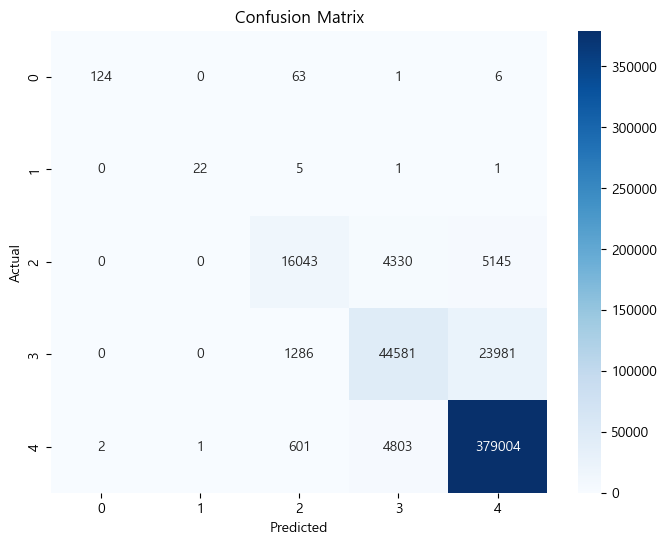

In [12]:
# 검증 세트 평가
final_pred = ensemble_model.predict(X_val)
final_acc = accuracy_score(y_val, final_pred)

print(f"Final Ensemble Accuracy: {final_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, final_pred))

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, final_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()